In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags
#from scipy.signal import correlate
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Identify peaks in salinity and SCHA/bc filtered signals to identify events and eventually create the intensity-duration plot

## cosine lanczos filter

In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [3]:
#load the SCHA filtered signal for Point Reyes 
#use Eli's SCHA filter subtide that I then subtracted the 40 day box car from
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes['datetime'] = pd.to_datetime(ptreyes['datetime'],format=dtformat)
pr_filt=ptreyes[['datetime','box_40d_filt']].rename(columns={"box_40d_filt": "Residual"})
pr_filt.set_index("datetime",inplace=True)
pr_filt

,Residual
datetime,
2012-01-03 01:30:00,NaN
2012-01-03 02:00:00,NaN
2012-01-03 02:30:00,NaN
2012-01-03 03:00:00,NaN
2012-01-03 03:30:00,NaN
...,...
2023-12-29 20:30:00,NaN
2023-12-29 21:00:00,NaN
2023-12-29 21:30:00,NaN


In [4]:
pr_filt.Residual[2000:2100].values

array([ 1.96859375e-03, -2.80729167e-05, -1.82536458e-03, -3.52328125e-03,
       -5.22177083e-03, -6.82083333e-03, -8.22041667e-03, -9.62046875e-03,
       -1.09209375e-02, -1.21218229e-02, -1.31230729e-02, -1.41247396e-02,
       -1.50267187e-02, -1.58290104e-02, -1.65315625e-02, -1.71343750e-02,
       -1.76373958e-02, -1.80406250e-02, -1.83440625e-02, -1.86476563e-02,
       -1.88514063e-02, -1.89553125e-02, -1.90592708e-02, -1.90632813e-02,
       -1.89673437e-02, -1.89714062e-02, -1.87754688e-02, -1.86794792e-02,
       -1.84833854e-02, -1.81871875e-02, -1.79908333e-02, -1.77942708e-02,
       -1.74975000e-02, -1.72004687e-02, -1.70031250e-02, -1.67054688e-02,
       -1.64073958e-02, -1.62089583e-02, -1.59100000e-02, -1.57105729e-02,
       -1.55106250e-02, -1.53100521e-02, -1.52088542e-02, -1.51069792e-02,
       -1.51043750e-02, -1.51009896e-02, -1.50967708e-02, -1.51917187e-02,
       -1.52857292e-02, -1.53787500e-02, -1.55707292e-02, -1.58616667e-02,
       -1.61515104e-02, -

<AxesSubplot:xlabel='datetime'>

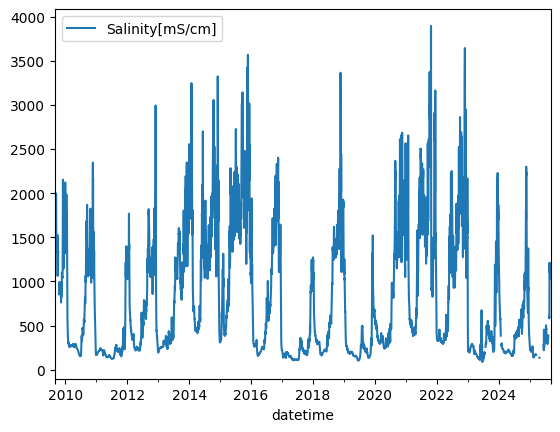

In [5]:
#load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)


sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
jp_filt=filter_timeseries(jp)

hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
hol2_dms.set_index("datetime",inplace=True)
hol2_dms=hol2_dms.asfreq('15min')
hol2_dms_filt=filter_timeseries(hol2_dms)

frk=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk=frk.rename(columns={"value": "Salinity[mS/cm]"})
frk['datetime']=pd.to_datetime(frk['datetime'],format=dtformat)
frk.set_index("datetime",inplace=True)
frk=frk.asfreq('15min')
frk_filt=filter_timeseries(frk)

jp_filt.plot()

In [6]:
# # save these 2 filtered datasets so we don't have to keep doing this
# jp_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/jersey_point_jer_sjj_filled_cl_filtered.csv")
# hol2_dms_filt.to_csv("/global/scratch/users/jennaisrael/time_varying_data/salinity/holland_cut_hol2_cl_filtered.csv")

In [7]:
#downsample the salinity data to also be every half hour
jp_filt=jp_filt.resample('30min').mean()
hol2_dms_filt=hol2_dms_filt.resample('30min').mean()

In [8]:
#what are the time frames of these data?
print("Point Reyes SCHA & BC filt time range: "+str(pr_filt.first_valid_index())+" - "+str(pr_filt.last_valid_index()))
print("Jersey Point time range: "+str(jp_filt.first_valid_index())+" - "+str(jp_filt.last_valid_index()))
print("Franks Tract time range: "+str(frk_filt.first_valid_index())+" - "+str(frk_filt.last_valid_index()))
print("Holland Cut time range: "+str(hol2_dms_filt.first_valid_index())+" - "+str(hol2_dms_filt.last_valid_index()))


Point Reyes SCHA & BC filt time range: 2012-02-12 01:30:00 - 2023-11-19 22:30:00
Jersey Point time range: 2009-09-04 15:00:00 - 2025-08-29 01:30:00
Franks Tract time range: 2015-07-05 04:00:00 - 2025-07-10 14:00:00
Holland Cut time range: 2009-09-07 16:00:00 - 2025-09-03 19:00:00


# Confine our search to water years 2013 to 2024

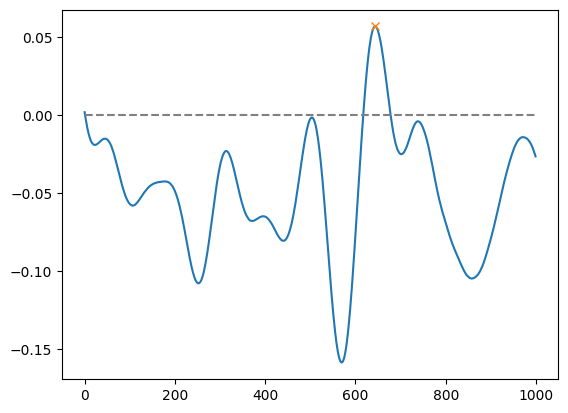

In [9]:
# Try out python's peak finding method in the signal toolbox
pr_trim=pr_filt.Residual[2000:3000].values
peaks, _ = find_peaks(pr_trim, height=0)

plt.plot(pr_trim)

plt.plot(peaks, pr_trim[peaks], "x")

plt.plot(np.zeros_like(pr_trim), "--", color="gray")

plt.show()


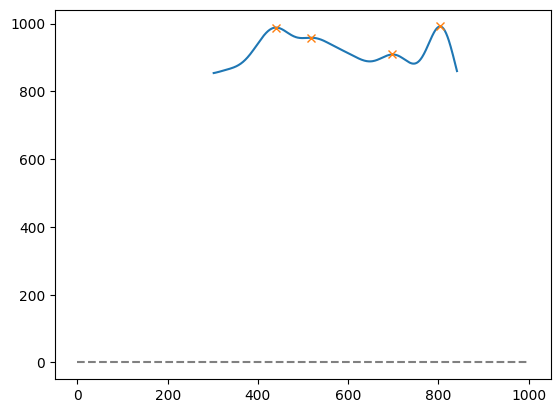

In [10]:
#repeat for salinity (harder)
jp_trim=jp_filt['Salinity[mS/cm]'][2000:3000].values
peaks, _ = find_peaks(jp_trim, height=0)

plt.plot(jp_trim)

plt.plot(peaks, jp_trim[peaks], "x")

plt.plot(np.zeros_like(jp_trim), "--", color="gray")

plt.show()

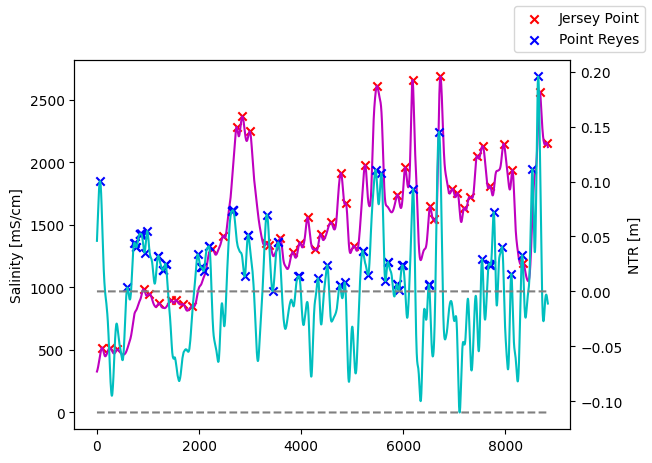

47 peaks identified for Jersey Point
85 peaks identified for Point Reyes


In [11]:
#try instead looking at a range we have examined previously 
jp_f2020=jp_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
pr_f2020=pr_filt['Residual'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peaksjp, _ = find_peaks(jp_f2020, height=0)
peakspr, _ = find_peaks(pr_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_f2020,color='m')
ax.scatter(peaksjp, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_f2020,color='c')
ax2.scatter(peakspr, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

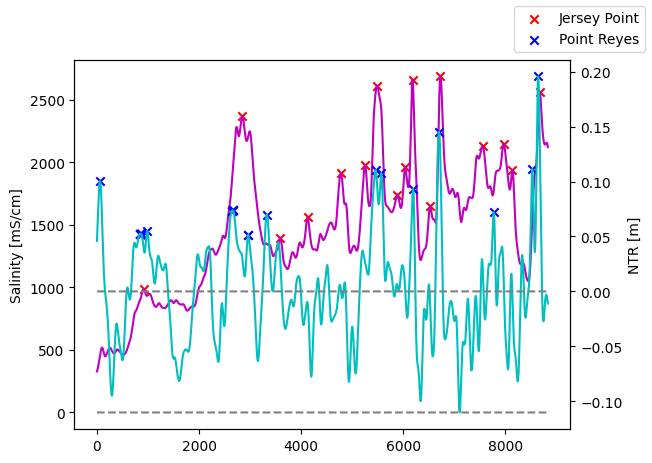

16 peaks identified for Jersey Point
30 peaks identified for Point Reyes


In [12]:
#repeat but with a threshold for prominence 
peaksjp, _ = find_peaks(jp_f2020, prominence=100)
peakspr, _ = find_peaks(pr_f2020, height=0.05)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_f2020,color='m')
ax.scatter(peaksjp, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')

ax2=ax.twinx() 
ax2.plot(pr_f2020,color='c')
ax2.scatter(peakspr, pr_f2020[peakspr], label="Point Reyes",marker="x",color='b')
ax2.plot(np.zeros_like(pr_f2020), "--", color="gray")
ax2.set_ylabel('NTR [m]')

fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakspr))+' peaks identified for Point Reyes')

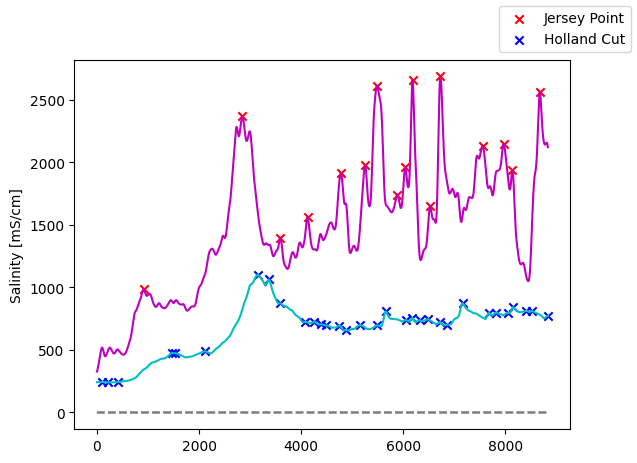

16 peaks identified for Jersey Point
32 peaks identified for Holland Cut


In [13]:
#Salinity 
hol2_f2020=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2020,7,1):datetime(2021,1,1)].values
peakshol2, _ = find_peaks(hol2_f2020, height=0)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_f2020,color='m')
ax.scatter(peaksjp, jp_f2020[peaksjp], label="Jersey Point",marker="x",color='r')
ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

ax.plot(hol2_f2020,color='c')
ax.scatter(peakshol2, hol2_f2020[peakshol2], label="Holland Cut",marker="x",color='b')
ax.plot(np.zeros_like(hol2_f2020), "--", color="gray")


fig.legend()

plt.show()
print(str(len(peaksjp))+' peaks identified for Jersey Point')
print(str(len(peakshol2))+' peaks identified for Holland Cut')

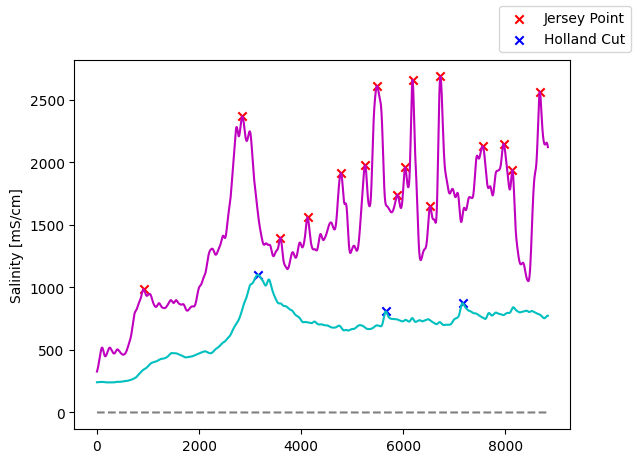

16 peaks identified for Jersey Point
3 peaks identified for Holland Cut


In [14]:
# probably need a minimum peak height for salinity
peaksjp100, _ = find_peaks(jp_f2020, prominence=100) #height is relative to 0! Not relative to the local "baseline", prominence is relative to baseline
peakshol2100, _ = find_peaks(hol2_f2020, prominence=100)

fig, ax= plt.subplots(sharex=True)
ax.plot(jp_f2020,color='m')
ax.scatter(peaksjp100, jp_f2020[peaksjp100], label="Jersey Point",marker="x",color='r')
ax.plot(np.zeros_like(jp_f2020), "--", color="gray")
ax.set_ylabel('Salinity [mS/cm]')
#plot salinity on the same axis this time

ax.plot(hol2_f2020,color='c')
ax.scatter(peakshol2100, hol2_f2020[peakshol2100], label="Holland Cut",marker="x",color='b')
#ax.plot(np.zeros_like(hol2_f2020), "--", color="gray")


fig.legend()

plt.show()
print(str(len(peaksjp100))+' peaks identified for Jersey Point')
print(str(len(peakshol2100))+' peaks identified for Holland Cut')

# Can we use the max cross-correlation (lag) to inform this analysis?

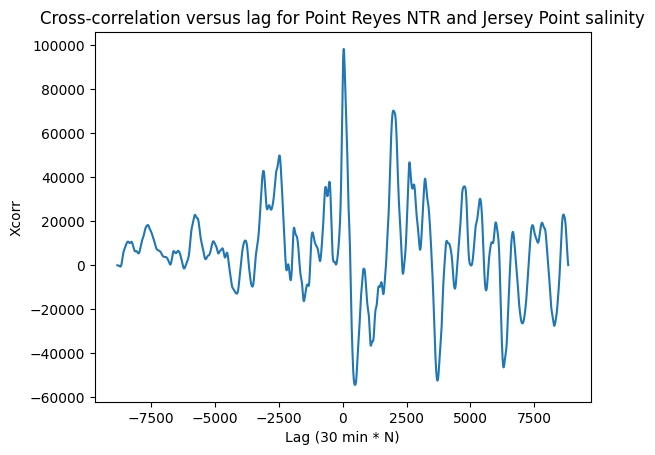

Lag of max cross-correlation is 18.5 hours


In [15]:
corr = correlate(jp_f2020, pr_f2020)
lags = correlation_lags(len(jp_f2020), len(pr_f2020))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Point Reyes NTR and Jersey Point salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

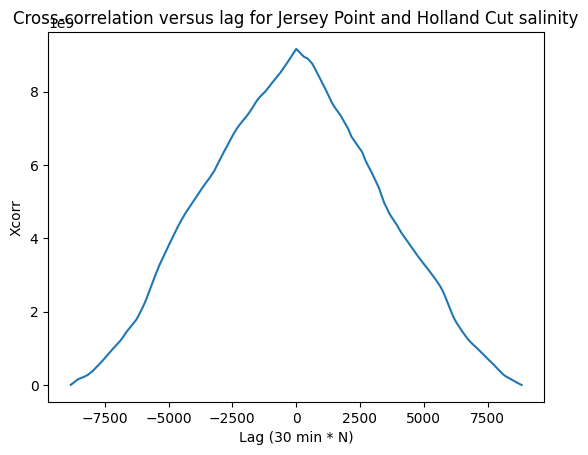

Lag of max cross-correlation is 0.0 hours


In [16]:
# What about holland cut and jersey point?
corr = correlate(hol2_f2020, jp_f2020)
lags = correlation_lags(len(hol2_f2020), len(jp_f2020))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.5)+ ' hours')

In [17]:
# #load the jersey point data, use the sjj signal to gap fill the jer, and load the holland cut salinity data, filter with cosine lanczos filter
# jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
# jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
# jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
# jer_dms.set_index("datetime",inplace=True)


# sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
# sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
# sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
# sjj_dms.set_index("datetime",inplace=True)

# #gapfill
# jp=jer_dms.fillna(sjj_dms)
# jp=jp.asfreq('15min')
# jp_filt=filter_timeseries(jp)

# hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
# hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "Salinity[mS/cm]"})
# hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
# hol2_dms.set_index("datetime",inplace=True)
# hol2_dms=hol2_dms.asfreq('15min')
# hol2_dms_filt=filter_timeseries(hol2_dms)


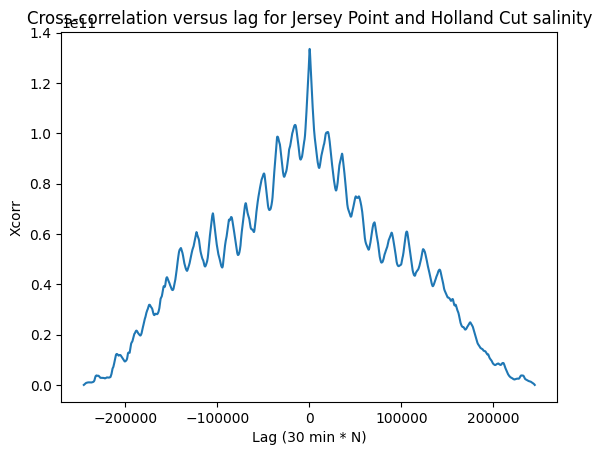

Lag of max cross-correlation is 86.75 hours


In [18]:
# Does this change if we look at a longer signal and go back to the 15 minute version?
hol2_x=hol2_dms_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values # need to fill the gaps to calculate the cross correlation
jp_x=jp_filt['Salinity[mS/cm]'].loc[datetime(2010,9,8):datetime(2024,8,28)].interpolate().values
corr = correlate(hol2_x, jp_x)
lags = correlation_lags(len(hol2_x), len(jp_x))
fig, ax= plt.subplots()
ax.plot(lags,corr)
ax.set_xlabel('Lag (30 min * N)')
ax.set_ylabel('Xcorr')
ax.set_title('Cross-correlation versus lag for Jersey Point and Holland Cut salinity')
plt.show()
print('Lag of max cross-correlation is '+ str(lags[corr.argmax()]*0.25)+ ' hours')

# Identify subtidal pumping events

In [19]:
#put all the variables in one array, need to cut it off before the last array begins (pr 2012-02-12) and before the first array ends (pr 2023-11-19)
df_raw=pd.concat([pr_filt.rename(columns={"Residual": "pr"}),jp_filt.rename(columns={"Salinity[mS/cm]": "jp"}),frk_filt.rename(columns={"Salinity[mS/cm]": "frk"}),hol2_dms_filt.rename(columns={"Salinity[mS/cm]": "hol2"})],axis=1)
df=df_raw.loc[datetime(2012,2,13):datetime(2023,11,18)]#.interpolate()

In [20]:
frk_filt

,Salinity[mS/cm],user_flag
datetime,,
2015-07-01 00:00:00,NaN,NaN
2015-07-01 00:15:00,NaN,NaN
2015-07-01 00:30:00,NaN,NaN
2015-07-01 00:45:00,NaN,NaN
2015-07-01 01:00:00,NaN,NaN
...,...,...
2025-07-14 17:00:00,NaN,NaN
2025-07-14 17:15:00,NaN,NaN
2025-07-14 17:30:00,NaN,NaN


In [21]:
df

,pr,jp,frk,user_flag,hol2
datetime,,,,,
2012-02-13 00:00:00,0.084324,471.977879,NaN,NaN,497.771983
2012-02-13 00:30:00,0.082788,472.048196,NaN,NaN,497.555941
2012-02-13 01:00:00,0.081049,472.106529,NaN,NaN,497.334855
2012-02-13 01:30:00,0.079207,472.151668,NaN,NaN,497.108795
2012-02-13 02:00:00,0.077361,472.182421,NaN,NaN,496.877852
...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1068.532464,205.590816,NaN,216.047225
2023-11-17 23:15:00,NaN,NaN,205.787840,NaN,NaN
2023-11-17 23:30:00,0.207101,1073.346700,205.988822,NaN,216.144973


In [22]:
df['datetime']=df.index.values
df['month']=df.index.month.values
df['year']=df.index.year.values
df

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,pr,jp,frk,user_flag,hol2,datetime,month,year
datetime,,,,,,,,
2012-02-13 00:00:00,0.084324,471.977879,NaN,NaN,497.771983,2012-02-13 00:00:00,2,2012
2012-02-13 00:30:00,0.082788,472.048196,NaN,NaN,497.555941,2012-02-13 00:30:00,2,2012
2012-02-13 01:00:00,0.081049,472.106529,NaN,NaN,497.334855,2012-02-13 01:00:00,2,2012
2012-02-13 01:30:00,0.079207,472.151668,NaN,NaN,497.108795,2012-02-13 01:30:00,2,2012
2012-02-13 02:00:00,0.077361,472.182421,NaN,NaN,496.877852,2012-02-13 02:00:00,2,2012
...,...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1068.532464,205.590816,NaN,216.047225,2023-11-17 23:00:00,11,2023
2023-11-17 23:15:00,NaN,NaN,205.787840,NaN,NaN,2023-11-17 23:15:00,11,2023
2023-11-17 23:30:00,0.207101,1073.346700,205.988822,NaN,216.144973,2023-11-17 23:30:00,11,2023


In [23]:
# df_test=df.mask((df['month']<7) | (df['month']>11)|(df['year']==2021))
# df_test.pr.plot()

In [24]:
#I think I need to do this with a mask
#df.mask((df['A'] > 5) | (df['B'] < 3), 99)
df_f_wo21=df.mask((df['month']<7) | (df['month']>11)|(df['year']==2021)|(df['year']==2022))

In [25]:
#first find the datetimes with peaks at all locations, store them in logical columns e.g. pr_peak
#seems to be using the whole summer as a peak sometimes, set max width of 2 months 
maxw=60*24*2
minw=2
peakspr, _ = find_peaks(df_f_wo21.pr.values, height=0,width=(2,maxw))#,width=(0,maxw)) #this just gives the x locations of the peaks, need to convert to logical
peaksjp, _ = find_peaks(df_f_wo21.jp.values, prominence=10)#,width=(0,maxw))
peakshol2, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)#,width=(0,maxw))
peaksfrk, _ = find_peaks(df_f_wo21.frk.values, prominence=10)#,width=(0,maxw))
#peakshol210, _ = find_peaks(df_f_wo21.hol2.values, prominence=10)
idx=np.arange(0,len(df_f_wo21.pr.values))
df_f_wo21['pr_peak']=np.isin(idx,peakspr) #has the same shape as the first argument
df_f_wo21['jp_peak']=np.isin(idx,peaksjp)
df_f_wo21['hol2_peak']=np.isin(idx,peakshol2)
df_f_wo21['frk_peak']=np.isin(idx,peaksfrk)
df_f_wo21

,pr,jp,frk,user_flag,hol2,datetime,month,year,pr_peak,jp_peak,hol2_peak,frk_peak
datetime,,,,,,,,,,,,
2012-02-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 00:30:00,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 01:00:00,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 01:30:00,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
2012-02-13 02:00:00,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 23:00:00,0.206520,1068.532464,205.590816,NaN,216.047225,2023-11-17 23:00:00,11.0,2023.0,False,False,False,False
2023-11-17 23:15:00,NaN,NaN,205.787840,NaN,NaN,2023-11-17 23:15:00,11.0,2023.0,False,False,False,False
2023-11-17 23:30:00,0.207101,1073.346700,205.988822,NaN,216.144973,2023-11-17 23:30:00,11.0,2023.0,False,False,False,False


In [26]:
print(df_f_wo21['pr_peak'].sum())
print(df_f_wo21['jp_peak'].sum())
print(df_f_wo21['frk_peak'].sum())
print(df_f_wo21['hol2_peak'].sum())

89
88
43
28


In [27]:
# as a first pass, how many events are there where there is a true value in all columns in the 24 hours after the pr peak?
peak_pr24h=np.array([])
peak_jp24h=np.array([])
peak_hol224h=np.array([])
win=48 #number of samples in 24 hours
winh=win*5
for x in peakspr:
    if df_f_wo21.jp_peak[x:x+win].sum()>0:
        if df_f_wo21.hol2_peak[x:x+winh].sum()>0:            
            peak_pr24h=np.append(peak_pr24h,x)
            peak_jp24h=np.append(peak_jp24h,int(x+df_f_wo21.jp_peak[x:x+win].argmax()))
            peak_hol224h=np.append(peak_hol224h,int(x+df_f_wo21.hol2_peak[x:x+winh].argmax()))
idx=np.arange(0,len(df_f_wo21.pr.values))
print(len(peak_pr24h))
df_f_wo21['all_peak_24h']=np.isin(idx,peak_pr24h)

12


In [28]:
peak_pr24h

array([ 8294., 25550., 27617., 30148., 31032., 31385., 42391., 42668.,
       43367., 45497., 47018., 47281.])

In [29]:
peak_jp24h

array([ 8312., 25577., 27639., 30183., 31039., 31421., 42423., 42679.,
       43384., 45505., 47049., 47309.])

In [30]:
peak_hol224h

array([ 8484., 25664., 27775., 30275., 31128., 31396., 42415., 42821.,
       43517., 45650., 47055., 47297.])

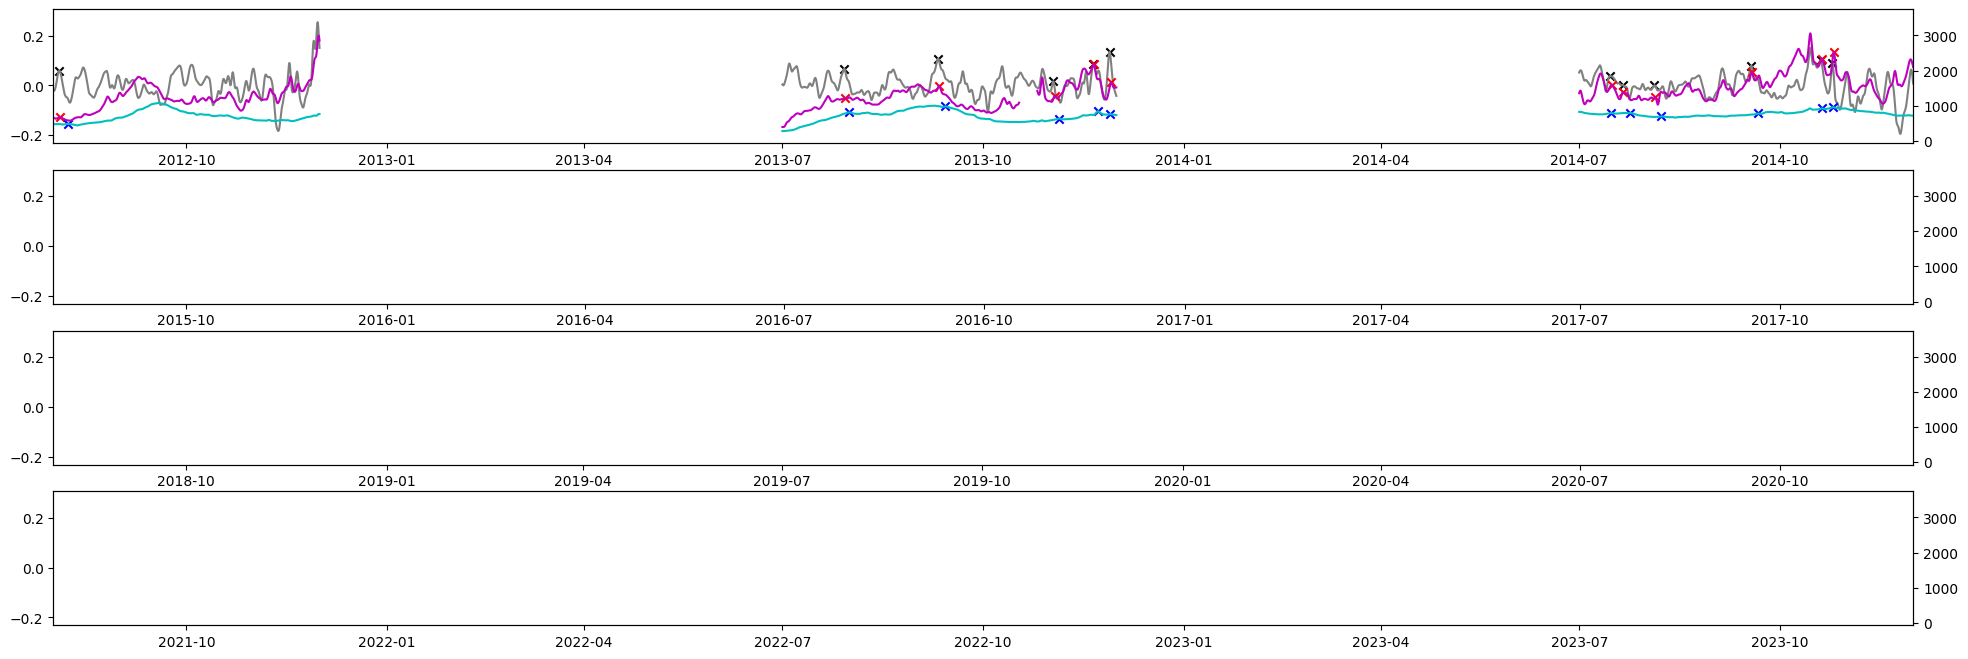

In [31]:
# try plotting these 19 events, split the period of time into 4 sections
fig, ax =plt.subplots(4,1,sharey=True,figsize=(24,8))

ax[0].plot(df_f_wo21.pr,color='grey')
ax[0].scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax1=ax[0].twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[0].set_xlim([datetime(2012,8,1),datetime(2014,12,1)])
ax1.set_xlim([datetime(2012,8,1),datetime(2014,12,1)])

ax[1].plot(df_f_wo21.pr,color='grey')
ax[1].scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax2=ax[1].twinx()
ax2.plot(df_f_wo21.jp,color='m')
ax2.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax2.plot(df_f_wo21.hol2,color='c')
ax2.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[1].set_xlim([datetime(2015,8,1),datetime(2017,12,1)])
ax2.set_xlim([datetime(2015,8,1),datetime(2017,12,1)])

ax[2].plot(df_f_wo21.pr,color='grey')
ax[2].scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax3=ax[2].twinx()
ax3.plot(df_f_wo21.jp,color='m')
ax3.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax3.plot(df_f_wo21.hol2,color='c')
ax3.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[2].set_xlim([datetime(2018,8,1),datetime(2020,12,1)])
ax3.set_xlim([datetime(2018,8,1),datetime(2020,12,1)])

ax[3].plot(df_f_wo21.pr,color='grey')
ax[3].scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax4=ax[3].twinx()
ax4.plot(df_f_wo21.jp,color='m')
ax4.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax4.plot(df_f_wo21.hol2,color='c')
ax4.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')
ax[3].set_xlim([datetime(2021,8,1),datetime(2023,12,1)])
ax4.set_xlim([datetime(2021,8,1),datetime(2023,12,1)])

plt.show()

(16283.0, 16405.0)

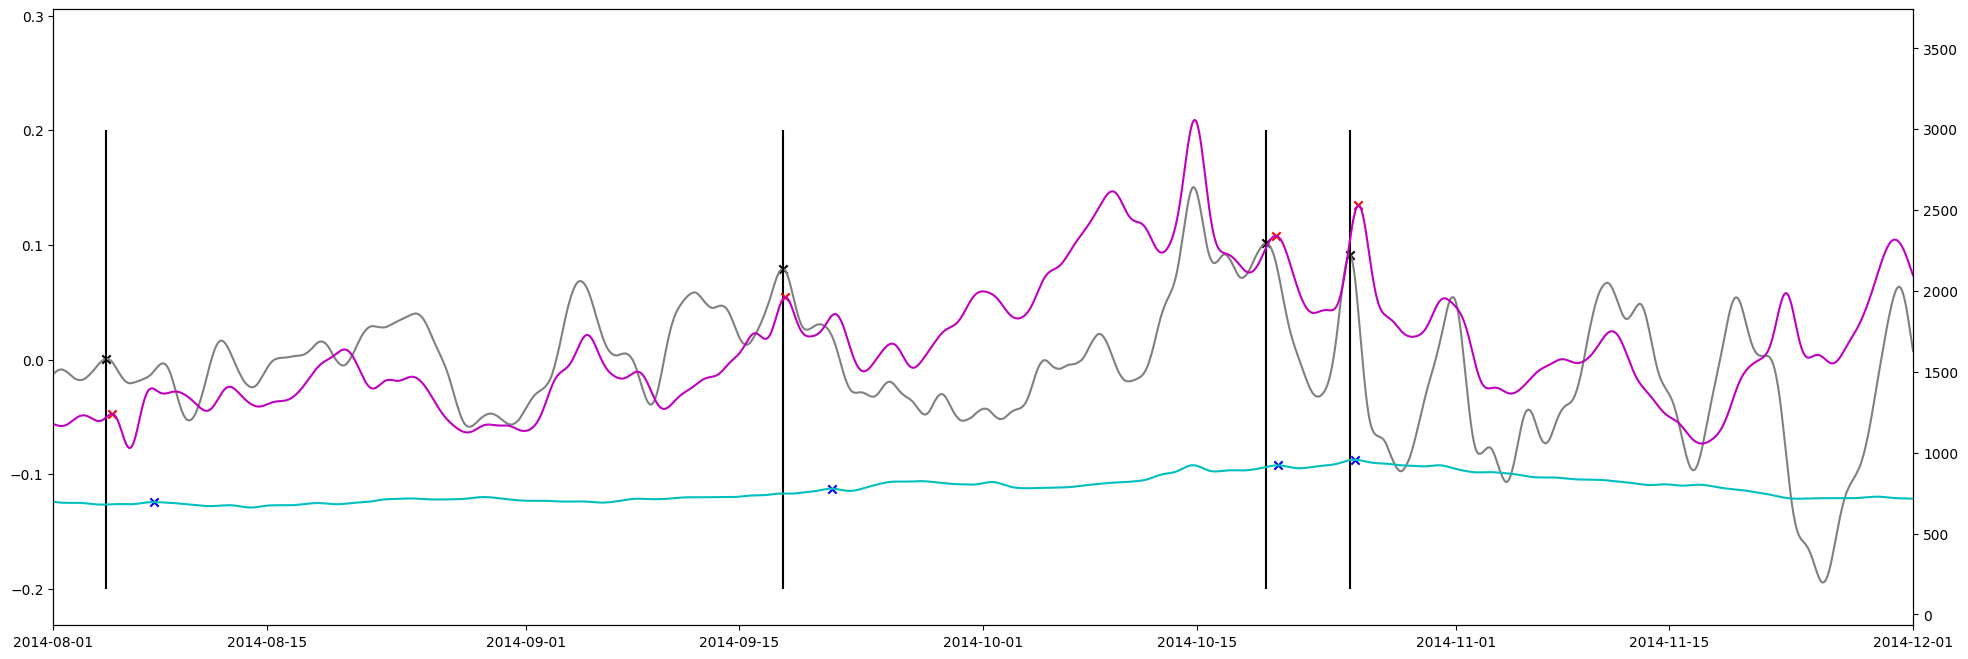

In [32]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol224h],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2014,12,1)])

(19205.0, 19327.0)

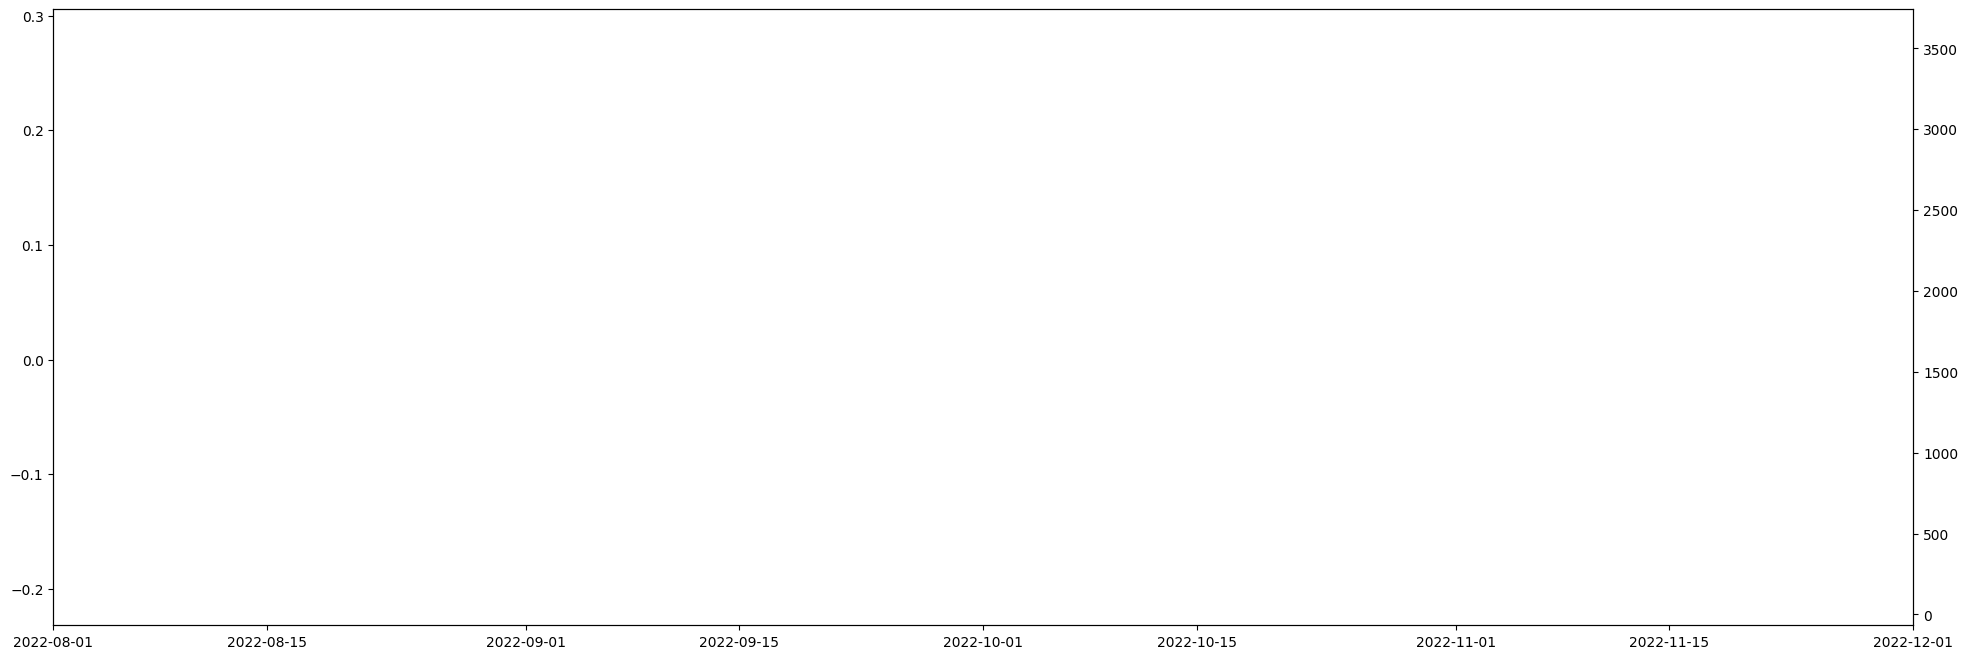

In [33]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])
ax1.set_xlim([datetime(2022,8,1),datetime(2022,12,1)])

(16283.0, 19692.0)

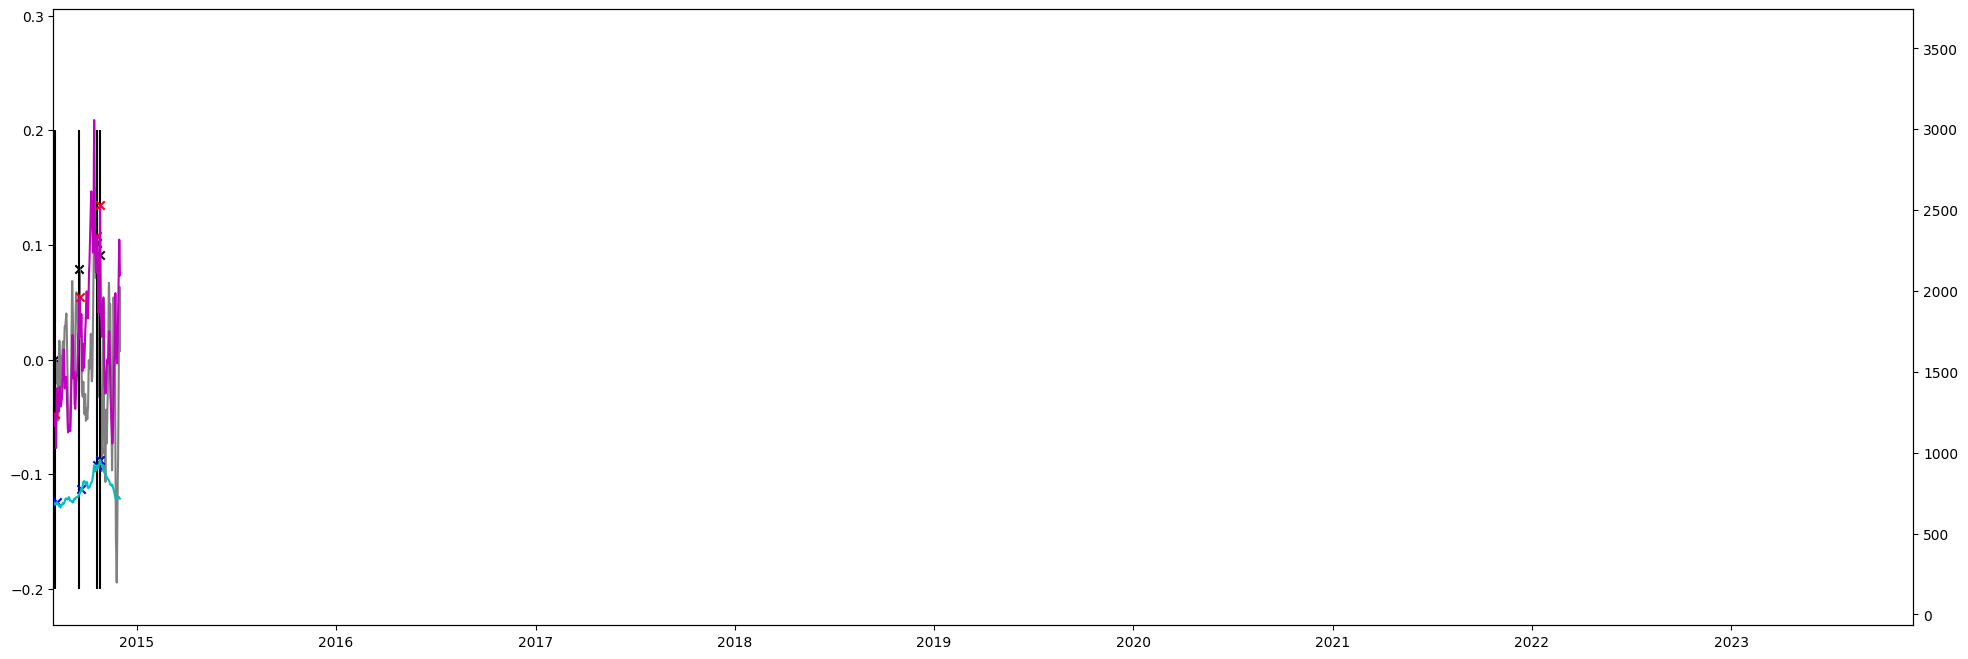

In [34]:
fig, ax =plt.subplots(figsize=(24,8))

ax.plot(df_f_wo21.pr,color='grey')
ax.scatter(df_f_wo21.datetime.iloc[peak_pr24h], df_f_wo21.pr.iloc[peak_pr24h], label="Point Reyes",marker="x",color='k')
ax.vlines(df_f_wo21.datetime.iloc[peak_pr24h], -0.2, 0.2, color='k')
ax1=ax.twinx()
ax1.plot(df_f_wo21.jp,color='m')
ax1.scatter(df_f_wo21.datetime.iloc[peak_jp24h],df_f_wo21.jp.iloc[peak_jp24h],label="Jersey Point",marker="x",color='r')
ax1.plot(df_f_wo21.hol2,color='c')
ax1.scatter(df_f_wo21.datetime.iloc[peak_hol224h],df_f_wo21.hol2.iloc[peak_hol224h],label="Holland Cut",marker="x",color='b')

# #what if we also plot all of the prominent hol2 peaks
# ax1.scatter(df_f_wo21.datetime.iloc[peakshol210],df_f_wo21.hol2.iloc[peakshol210],marker="*",color='k')

ax.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])
ax1.set_xlim([datetime(2014,8,1),datetime(2023,12,1)])